## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1    -19.719746     471.661536  -101.200398    -231.960902   
1            2    -19.719746     471.661536  -101.200398    -231.960902   
2            3    -19.719746     471.661536  -101.200398    -231.960902   
3            4    -19.719746     471.661536  -101.200398    -231.960902   
4            5    -19.719746     471.661536  -101.200398    -231.960902   
...        ...           ...            ...          ...            ...   
1752345     46    -12.920028     494.226632   -46.982710     -95.220702   
1752346     47    -12.920028     494.226632   -46.982710     -95.220702   
1752347     48    -12.920028     494.226632   -46.982710     -95.220702   
1752348     49    -12.920028     494.226632   -46.982710     -95.220702   
1752349     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns =['depth', 'Area_m2', 'Uw',
                 'buoyancy', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'diffusivity', 'temp_initial00', 'temp_heat01', 'temp_total05']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./saved_models/diffusion_model_finetuned.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns =  ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',  'temp_initial00', 'temp_heat01', 'temp_total05', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns =['depth', 'day_of_year', 'time_of_day','ice', 'snow', 'snowice', 'temp_initial00', 'temp_heat01']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m3_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m3_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m0_pred], dim=-1)

        m4_pred = ice_model(m4_input)

        
        #print(m1_pred)
        
        if plot:
            m4_y_true = x[:, m4_output_column_ix[0]] * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
            m4_y_pred = m4_pred * torch.tensor(train_std[m4_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m4_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))


        #model 3
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m4_pred], dim=-1)
        m1_pred = heat_diff_model(m1_input)
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
            print("RMSE of after m3", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 4
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * std + mean
            m3_y_pred = m3_pred * std + mean
            rmse_models[ix, 4] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m4", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        y_true = x[:, m3_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m3_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth (m)", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    yticks_ix = np.array(ax[0].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[0].set_yticklabels(depth_label, rotation=0)
    ax[0].collections[0].colorbar.set_label("Actual Temperature ($^\circ$C)")

    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)")
    yticks_ix = np.array(ax[1].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[1].set_yticklabels(depth_label, rotation=0)
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    yticks_ix = np.array(ax[2].get_yticks()).astype(int)
    depth_label = yticks_ix / 2
    ax[2].set_yticklabels(depth_label, rotation=0)
    ax[2].collections[0].colorbar.set_label("Absolute Error ($^\circ$C)")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")



RMSE of after m0 0.5314539
RMSE of after m1 0.5038529
RMSE of after m3 5.120871
RMSE of after m4 3.6386616
RMSE of after m0 0.4850574
RMSE of after m1 0.33333546
RMSE of after m3 1.7648755
RMSE of after m4 1.5272887
RMSE of after m0 0.44246578
RMSE of after m1 0.27840084
RMSE of after m3 1.3197161
RMSE of after m4 1.2289269
RMSE of after m0 0.4490155
RMSE of after m1 0.22472136
RMSE of after m3 1.4988253
RMSE of after m4 1.4352196
RMSE of after m0 0.47466496
RMSE of after m1 0.2152792
RMSE of after m3 1.6031202
RMSE of after m4 1.541685
RMSE of after m0 0.5345552
RMSE of after m1 0.1999057
RMSE of after m3 1.7273943
RMSE of after m4 1.6645589
RMSE of after m0 0.6256702
RMSE of after m1 0.19395098
RMSE of after m3 1.922018
RMSE of after m4 1.8402807
RMSE of after m0 0.61222327
RMSE of after m1 0.18767081
RMSE of after m3 1.9541787
RMSE of after m4 1.86196
RMSE of after m0 0.5868373
RMSE of after m1 0.17779528
RMSE of after m3 1.7450279
RMSE of after m4 1.667784
RMSE of after m0 0.588341

RMSE of after m1 0.122237876
RMSE of after m3 1.4064394
RMSE of after m4 1.235852
RMSE of after m0 0.50419486
RMSE of after m1 0.12118967
RMSE of after m3 1.4199942
RMSE of after m4 1.2539203
RMSE of after m0 0.49733773
RMSE of after m1 0.120582305
RMSE of after m3 1.3961564
RMSE of after m4 1.2301906
RMSE of after m0 0.50673884
RMSE of after m1 0.122711
RMSE of after m3 1.3790536
RMSE of after m4 1.2144468
RMSE of after m0 0.5206697
RMSE of after m1 0.12561485
RMSE of after m3 1.3604858
RMSE of after m4 1.197475
RMSE of after m0 0.5072432
RMSE of after m1 0.12098831
RMSE of after m3 1.3414739
RMSE of after m4 1.1803542
RMSE of after m0 0.51604384
RMSE of after m1 0.12351066
RMSE of after m3 1.3297273
RMSE of after m4 1.169534
RMSE of after m0 0.5234601
RMSE of after m1 0.12623414
RMSE of after m3 1.2994963
RMSE of after m4 1.1389018
RMSE of after m0 0.52533466
RMSE of after m1 0.12719429
RMSE of after m3 1.2546437
RMSE of after m4 1.0950229
RMSE of after m0 0.5200119
RMSE of after m1 

RMSE of after m0 0.36482868
RMSE of after m1 0.31489336
RMSE of after m3 2.9986594
RMSE of after m4 3.1396725
RMSE of after m0 0.3637059
RMSE of after m1 0.31110644
RMSE of after m3 2.8614514
RMSE of after m4 3.0622888
RMSE of after m0 0.35577527
RMSE of after m1 0.30178148
RMSE of after m3 2.8591032
RMSE of after m4 3.03249
RMSE of after m0 0.2958683
RMSE of after m1 0.24489869
RMSE of after m3 2.7319803
RMSE of after m4 2.797625
RMSE of after m0 0.25922808
RMSE of after m1 0.21154241
RMSE of after m3 2.6136284
RMSE of after m4 2.8127363
RMSE of after m0 0.2690261
RMSE of after m1 0.2223293
RMSE of after m3 2.6234298
RMSE of after m4 2.8361995
RMSE of after m0 0.29146573
RMSE of after m1 0.24352959
RMSE of after m3 2.63892
RMSE of after m4 2.859354
RMSE of after m0 0.30149007
RMSE of after m1 0.2525583
RMSE of after m3 2.7092166
RMSE of after m4 2.9030674
RMSE of after m0 0.25957003
RMSE of after m1 0.21416561
RMSE of after m3 2.6651328
RMSE of after m4 2.8814647
RMSE of after m0 0.25

RMSE of after m0 0.22405563
RMSE of after m1 0.19509365
RMSE of after m3 4.4666657
RMSE of after m4 5.702485
RMSE of after m0 0.24917044
RMSE of after m1 0.21721646
RMSE of after m3 4.6142883
RMSE of after m4 5.925714
RMSE of after m0 0.2462666
RMSE of after m1 0.2165679
RMSE of after m3 4.4642096
RMSE of after m4 5.743503
RMSE of after m0 0.23462453
RMSE of after m1 0.20503058
RMSE of after m3 4.5357723
RMSE of after m4 5.807277
RMSE of after m0 0.22098428
RMSE of after m1 0.19087702
RMSE of after m3 4.5794926
RMSE of after m4 5.8117256
RMSE of after m0 0.21613854
RMSE of after m1 0.18476169
RMSE of after m3 4.9206514
RMSE of after m4 6.2263603
RMSE of after m0 0.22261769
RMSE of after m1 0.1930112
RMSE of after m3 4.9535933
RMSE of after m4 6.2664404
RMSE of after m0 0.21803018
RMSE of after m1 0.18945763
RMSE of after m3 4.895386
RMSE of after m4 6.245179
RMSE of after m0 0.21493618
RMSE of after m1 0.1878041
RMSE of after m3 4.8081374
RMSE of after m4 6.1879416
RMSE of after m0 0.2

RMSE of after m3 5.1456985
RMSE of after m4 6.2496448
RMSE of after m0 0.16557693
RMSE of after m1 0.15758409
RMSE of after m3 5.3925056
RMSE of after m4 6.4585094
RMSE of after m0 0.183621
RMSE of after m1 0.18095236
RMSE of after m3 5.5587
RMSE of after m4 6.628821
RMSE of after m0 0.18623653
RMSE of after m1 0.18521772
RMSE of after m3 5.4845867
RMSE of after m4 6.5606217
RMSE of after m0 0.17783651
RMSE of after m1 0.17472349
RMSE of after m3 5.6698594
RMSE of after m4 6.6637335
RMSE of after m0 0.17680685
RMSE of after m1 0.17340532
RMSE of after m3 5.765426
RMSE of after m4 6.6594563
RMSE of after m0 0.18804005
RMSE of after m1 0.18600859
RMSE of after m3 5.5894613
RMSE of after m4 6.518844
RMSE of after m0 0.18691404
RMSE of after m1 0.18427499
RMSE of after m3 5.531812
RMSE of after m4 6.5171013
RMSE of after m0 0.21732391
RMSE of after m1 0.21351336
RMSE of after m3 5.3193974
RMSE of after m4 6.4405785
RMSE of after m0 0.20833535
RMSE of after m1 0.20397823
RMSE of after m3 4.

RMSE of after m0 0.68305343
RMSE of after m1 0.2526973
RMSE of after m3 6.468114
RMSE of after m4 5.1307297
RMSE of after m0 0.6517496
RMSE of after m1 0.2532765
RMSE of after m3 6.096281
RMSE of after m4 4.9054456
RMSE of after m0 0.6516688
RMSE of after m1 0.24933131
RMSE of after m3 6.238315
RMSE of after m4 4.9585247
RMSE of after m0 0.6531937
RMSE of after m1 0.2466741
RMSE of after m3 6.3373556
RMSE of after m4 5.0109987
RMSE of after m0 0.64930207
RMSE of after m1 0.24399513
RMSE of after m3 6.503181
RMSE of after m4 5.0601172
RMSE of after m0 0.64612925
RMSE of after m1 0.2395293
RMSE of after m3 6.703064
RMSE of after m4 5.117501
RMSE of after m0 0.65579534
RMSE of after m1 0.2397391
RMSE of after m3 6.7350616
RMSE of after m4 5.1807327
RMSE of after m0 0.67955196
RMSE of after m1 0.24694501
RMSE of after m3 6.484678
RMSE of after m4 5.0217953
RMSE of after m0 0.6949097
RMSE of after m1 0.25825268
RMSE of after m3 5.825189
RMSE of after m4 4.6327252
RMSE of after m0 0.6737551


RMSE of after m0 0.59499645
RMSE of after m1 0.16153312
RMSE of after m3 1.3871709
RMSE of after m4 1.2523721
RMSE of after m0 0.5930585
RMSE of after m1 0.16155043
RMSE of after m3 1.3460763
RMSE of after m4 1.2167189
RMSE of after m0 0.5868873
RMSE of after m1 0.15873775
RMSE of after m3 1.1636612
RMSE of after m4 1.0533663
RMSE of after m0 0.5794499
RMSE of after m1 0.15670244
RMSE of after m3 1.1830392
RMSE of after m4 1.0720147
RMSE of after m0 0.5820948
RMSE of after m1 0.15584482
RMSE of after m3 1.1605711
RMSE of after m4 1.054285
RMSE of after m0 0.5868513
RMSE of after m1 0.15594605
RMSE of after m3 1.1161315
RMSE of after m4 1.0071759
RMSE of after m0 0.58719397
RMSE of after m1 0.15667722
RMSE of after m3 1.1741151
RMSE of after m4 1.0607612
RMSE of after m0 0.5804504
RMSE of after m1 0.15515253
RMSE of after m3 1.0829527
RMSE of after m4 0.9781521
RMSE of after m0 0.58312345
RMSE of after m1 0.15498088
RMSE of after m3 0.98105234
RMSE of after m4 0.8890008
RMSE of after m0

RMSE of after m4 1.8515366
RMSE of after m0 0.6256225
RMSE of after m1 0.13604498
RMSE of after m3 2.729635
RMSE of after m4 1.9744899
RMSE of after m0 0.6245797
RMSE of after m1 0.13692628
RMSE of after m3 2.8924706
RMSE of after m4 2.0574086
RMSE of after m0 0.62140924
RMSE of after m1 0.13732177
RMSE of after m3 2.8178198
RMSE of after m4 2.0297
RMSE of after m0 0.6194037
RMSE of after m1 0.13692936
RMSE of after m3 2.896745
RMSE of after m4 2.0719311
RMSE of after m0 0.6161852
RMSE of after m1 0.1361489
RMSE of after m3 2.9373558
RMSE of after m4 2.0887508
RMSE of after m0 0.6370799
RMSE of after m1 0.14002624
RMSE of after m3 3.1903582
RMSE of after m4 2.2393556
RMSE of after m0 0.6387295
RMSE of after m1 0.13842714
RMSE of after m3 3.1435804
RMSE of after m4 2.1874971
RMSE of after m0 0.6423055
RMSE of after m1 0.13780157
RMSE of after m3 3.2101471
RMSE of after m4 2.224466
RMSE of after m0 0.6450884
RMSE of after m1 0.13832226
RMSE of after m3 3.2414985
RMSE of after m4 2.249250

RMSE of after m0 0.29782107
RMSE of after m1 0.24207361
RMSE of after m3 4.1353188
RMSE of after m4 4.7237754
RMSE of after m0 0.31534624
RMSE of after m1 0.25690103
RMSE of after m3 4.1616364
RMSE of after m4 4.6844597
RMSE of after m0 0.31490767
RMSE of after m1 0.25537646
RMSE of after m3 3.9364195
RMSE of after m4 4.4828334
RMSE of after m0 0.30972952
RMSE of after m1 0.2504787
RMSE of after m3 3.87773
RMSE of after m4 4.441147
RMSE of after m0 0.2918704
RMSE of after m1 0.23302972
RMSE of after m3 3.8459806
RMSE of after m4 4.4387474
RMSE of after m0 0.29379326
RMSE of after m1 0.23565955
RMSE of after m3 3.9286942
RMSE of after m4 4.59739
RMSE of after m0 0.32562712
RMSE of after m1 0.26546124
RMSE of after m3 3.9351687
RMSE of after m4 4.6276536
RMSE of after m0 0.30385268
RMSE of after m1 0.2440987
RMSE of after m3 3.941516
RMSE of after m4 4.546488
RMSE of after m0 0.29765716
RMSE of after m1 0.23907802
RMSE of after m3 3.9349911
RMSE of after m4 4.5614033
RMSE of after m0 0.3

RMSE of after m0 0.20033863
RMSE of after m1 0.1797656
RMSE of after m3 4.5865407
RMSE of after m4 5.9422984
RMSE of after m0 0.20358418
RMSE of after m1 0.18513249
RMSE of after m3 4.5458417
RMSE of after m4 5.9285293
RMSE of after m0 0.20715177
RMSE of after m1 0.18891001
RMSE of after m3 4.4721613
RMSE of after m4 5.8583145
RMSE of after m0 0.22062768
RMSE of after m1 0.19810222
RMSE of after m3 4.5810504
RMSE of after m4 5.866186
RMSE of after m0 0.22072545
RMSE of after m1 0.19936581
RMSE of after m3 4.3453474
RMSE of after m4 5.545608
RMSE of after m0 0.21940345
RMSE of after m1 0.19855021
RMSE of after m3 4.2958503
RMSE of after m4 5.4941697
RMSE of after m0 0.21931846
RMSE of after m1 0.19959983
RMSE of after m3 4.2501125
RMSE of after m4 5.459896
RMSE of after m0 0.21453914
RMSE of after m1 0.19581659
RMSE of after m3 4.2623873
RMSE of after m4 5.5172043
RMSE of after m0 0.20449395
RMSE of after m1 0.1879623
RMSE of after m3 4.1900506
RMSE of after m4 5.427281
RMSE of after m0

RMSE of after m0 0.2016933
RMSE of after m1 0.19502838
RMSE of after m3 4.716405
RMSE of after m4 5.549946
RMSE of after m0 0.23259692
RMSE of after m1 0.2242179
RMSE of after m3 4.9443374
RMSE of after m4 5.620406
RMSE of after m0 0.21113648
RMSE of after m1 0.20268644
RMSE of after m3 4.4785542
RMSE of after m4 5.2261853
RMSE of after m0 0.18935922
RMSE of after m1 0.18258727
RMSE of after m3 4.869056
RMSE of after m4 5.591469
RMSE of after m0 0.20362273
RMSE of after m1 0.19952878
RMSE of after m3 5.018657
RMSE of after m4 5.6499457
RMSE of after m0 0.21901558
RMSE of after m1 0.21542932
RMSE of after m3 5.2312794
RMSE of after m4 5.8096232
RMSE of after m0 0.24910611
RMSE of after m1 0.24513997
RMSE of after m3 5.554787
RMSE of after m4 6.0951676
RMSE of after m0 0.28698212
RMSE of after m1 0.27805543
RMSE of after m3 6.02037
RMSE of after m4 6.123719
RMSE of after m0 0.4126075
RMSE of after m1 0.37470222
RMSE of after m3 6.7293406
RMSE of after m4 6.231679
RMSE of after m0 0.51633

RMSE of after m0 0.6567076
RMSE of after m1 0.3463163
RMSE of after m3 1.9503909
RMSE of after m4 1.8429093
RMSE of after m0 0.6519644
RMSE of after m1 0.33427918
RMSE of after m3 1.8938565
RMSE of after m4 1.802121
RMSE of after m0 0.6598886
RMSE of after m1 0.32844135
RMSE of after m3 1.8277898
RMSE of after m4 1.7264853
RMSE of after m0 0.67581797
RMSE of after m1 0.33194724
RMSE of after m3 1.811129
RMSE of after m4 1.7179607
RMSE of after m0 0.67346144
RMSE of after m1 0.3323516
RMSE of after m3 1.8464931
RMSE of after m4 1.7551979
RMSE of after m0 0.6711105
RMSE of after m1 0.3314866
RMSE of after m3 1.6300344
RMSE of after m4 1.5604388
RMSE of after m0 0.7173381
RMSE of after m1 0.36650503
RMSE of after m3 1.6439264
RMSE of after m4 1.5576844
RMSE of after m0 0.6973191
RMSE of after m1 0.3721568
RMSE of after m3 1.7337573
RMSE of after m4 1.6409162
RMSE of after m0 0.6933715
RMSE of after m1 0.36905
RMSE of after m3 1.6746641
RMSE of after m4 1.6149042
RMSE of after m0 0.6939558

RMSE of after m1 0.14489233
RMSE of after m3 1.753422
RMSE of after m4 1.4376849
RMSE of after m0 0.6154507
RMSE of after m1 0.1464118
RMSE of after m3 1.7637001
RMSE of after m4 1.4543605
RMSE of after m0 0.62780344
RMSE of after m1 0.14308274
RMSE of after m3 1.8985132
RMSE of after m4 1.5965871
RMSE of after m0 0.6206355
RMSE of after m1 0.14038771
RMSE of after m3 1.8204817
RMSE of after m4 1.5419639
RMSE of after m0 0.6241409
RMSE of after m1 0.14150396
RMSE of after m3 1.6375988
RMSE of after m4 1.4143064
RMSE of after m0 0.63441443
RMSE of after m1 0.14427306
RMSE of after m3 1.755413
RMSE of after m4 1.4940293
RMSE of after m0 0.6502491
RMSE of after m1 0.14806531
RMSE of after m3 1.841676
RMSE of after m4 1.555669
RMSE of after m0 0.6423674
RMSE of after m1 0.14573291
RMSE of after m3 2.0725415
RMSE of after m4 1.72682
RMSE of after m0 0.6350779
RMSE of after m1 0.14112997
RMSE of after m3 2.0169933
RMSE of after m4 1.6820518
RMSE of after m0 0.62110853
RMSE of after m1 0.1330

RMSE of after m4 3.3393636
RMSE of after m0 0.4756061
RMSE of after m1 0.37752485
RMSE of after m3 3.4292939
RMSE of after m4 3.4226515
RMSE of after m0 0.48676947
RMSE of after m1 0.38834095
RMSE of after m3 3.4828146
RMSE of after m4 3.460511
RMSE of after m0 0.47860435
RMSE of after m1 0.38142928
RMSE of after m3 3.479799
RMSE of after m4 3.4736655
RMSE of after m0 0.48990622
RMSE of after m1 0.3932028
RMSE of after m3 3.5212984
RMSE of after m4 3.5455635
RMSE of after m0 0.47820333
RMSE of after m1 0.3831631
RMSE of after m3 3.5070605
RMSE of after m4 3.5501924
RMSE of after m0 0.464101
RMSE of after m1 0.36926475
RMSE of after m3 3.5183709
RMSE of after m4 3.5360296
RMSE of after m0 0.47195604
RMSE of after m1 0.37554908
RMSE of after m3 3.5714223
RMSE of after m4 3.573589
RMSE of after m0 0.44940323
RMSE of after m1 0.3544607
RMSE of after m3 3.4717128
RMSE of after m4 3.51894
RMSE of after m0 0.41970122
RMSE of after m1 0.33323336
RMSE of after m3 3.4278677
RMSE of after m4 3.49

In [23]:
print(train_data.shape)
print(test_data.shape)
print(train_y_pred.shape)

(1051400, 45)
(700950, 45)
torch.Size([1051400, 1])


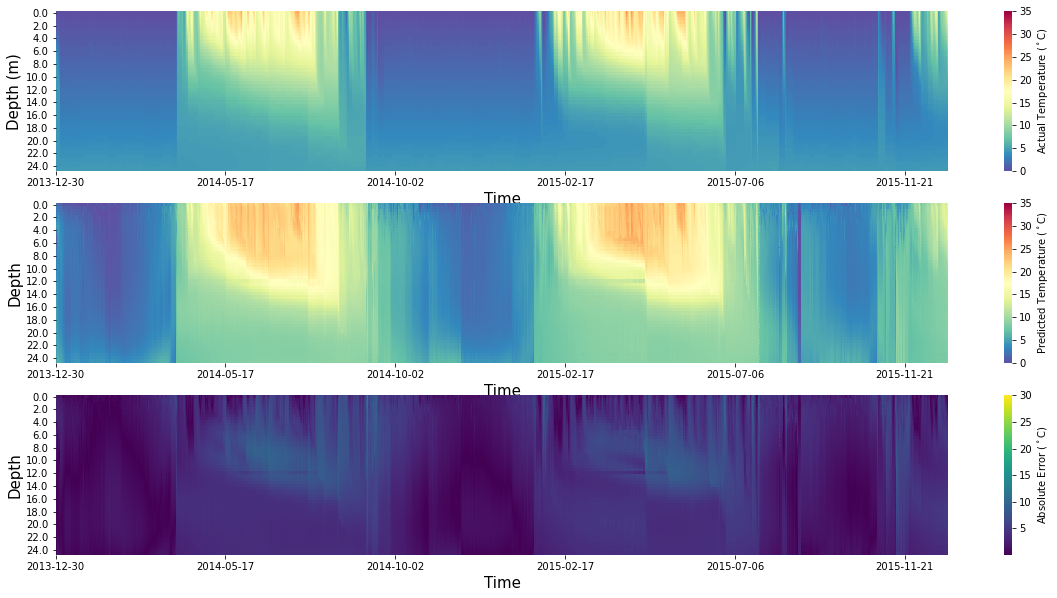

In [24]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

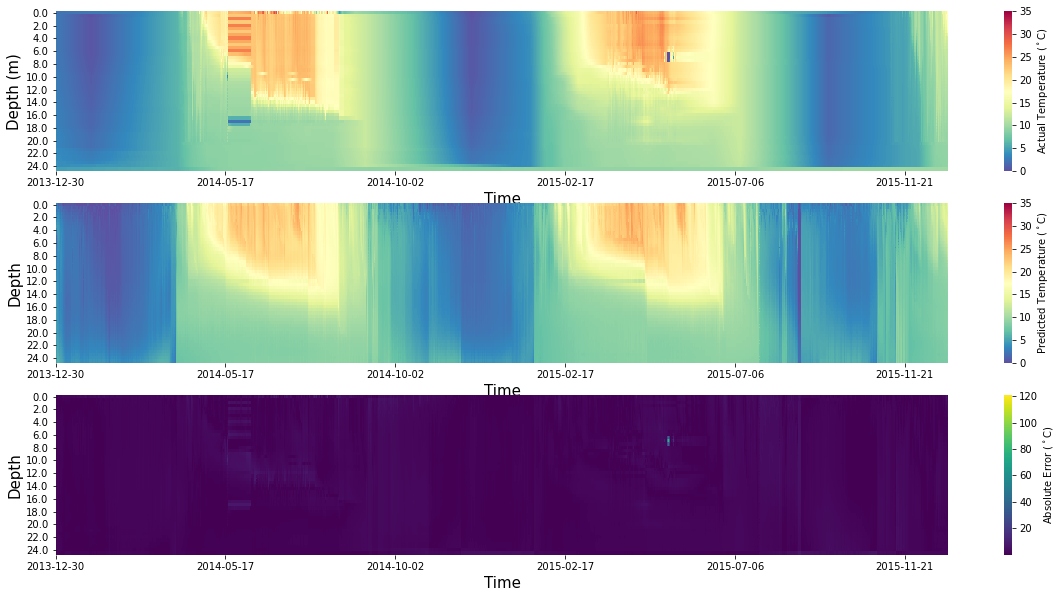

In [25]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [26]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.37945697
RMSE of after m1 0.300239
RMSE of after m3 3.7826662
RMSE of after m4 4.036107
RMSE of after m0 0.38390532
RMSE of after m1 0.30329219
RMSE of after m3 3.8206327
RMSE of after m4 4.055218
RMSE of after m0 0.38004932
RMSE of after m1 0.30009243
RMSE of after m3 3.8270564
RMSE of after m4 4.0900416
RMSE of after m0 0.37820458
RMSE of after m1 0.2988476
RMSE of after m3 3.827574
RMSE of after m4 4.125809
RMSE of after m0 0.3822854
RMSE of after m1 0.30282247
RMSE of after m3 3.887641
RMSE of after m4 4.206979
RMSE of after m0 0.36943722
RMSE of after m1 0.29134575
RMSE of after m3 3.72466
RMSE of after m4 4.0039034
RMSE of after m0 0.34807777
RMSE of after m1 0.2716508
RMSE of after m3 3.668336
RMSE of after m4 3.9571571
RMSE of after m0 0.34365284
RMSE of after m1 0.26721004
RMSE of after m3 3.6743917
RMSE of after m4 3.958639
RMSE of after m0 0.35424578
RMSE of after m1 0.27684575
RMSE of after m3 3.6985242
RMSE of after m4 4.0049963
RMSE of after m0 0.364621

RMSE of after m4 4.6105638
RMSE of after m0 0.29960877
RMSE of after m1 0.25081596
RMSE of after m3 3.9221308
RMSE of after m4 4.5858974
RMSE of after m0 0.3001285
RMSE of after m1 0.2496032
RMSE of after m3 3.9495199
RMSE of after m4 4.585748
RMSE of after m0 0.29470456
RMSE of after m1 0.24427775
RMSE of after m3 3.9600472
RMSE of after m4 4.549837
RMSE of after m0 0.30441597
RMSE of after m1 0.25289872
RMSE of after m3 3.937798
RMSE of after m4 4.5318923
RMSE of after m0 0.31066227
RMSE of after m1 0.25917596
RMSE of after m3 3.8564112
RMSE of after m4 4.431886
RMSE of after m0 0.31672755
RMSE of after m1 0.2654063
RMSE of after m3 3.8181973
RMSE of after m4 4.405618
RMSE of after m0 0.32698447
RMSE of after m1 0.27345386
RMSE of after m3 3.9094431
RMSE of after m4 4.5639277
RMSE of after m0 0.31884643
RMSE of after m1 0.2658074
RMSE of after m3 3.7790422
RMSE of after m4 4.304528
RMSE of after m0 0.29797268
RMSE of after m1 0.24919552
RMSE of after m3 3.8971243
RMSE of after m4 4.4

RMSE of after m1 0.22424999
RMSE of after m3 4.3063626
RMSE of after m4 4.83922
RMSE of after m0 0.24946342
RMSE of after m1 0.21249679
RMSE of after m3 4.5478
RMSE of after m4 5.045148
RMSE of after m0 0.25861588
RMSE of after m1 0.22439013
RMSE of after m3 4.931175
RMSE of after m4 5.3909636
RMSE of after m0 0.29518738
RMSE of after m1 0.2641693
RMSE of after m3 5.1900935
RMSE of after m4 5.6528215
RMSE of after m0 0.327258
RMSE of after m1 0.2930768
RMSE of after m3 4.5293355
RMSE of after m4 5.066327
RMSE of after m0 0.2772761
RMSE of after m1 0.24425682
RMSE of after m3 4.0020175
RMSE of after m4 4.465562
RMSE of after m0 0.2948067
RMSE of after m1 0.25878188
RMSE of after m3 4.0813046
RMSE of after m4 4.5289683
RMSE of after m0 0.26631847
RMSE of after m1 0.23238187
RMSE of after m3 3.840633
RMSE of after m4 4.2812004
RMSE of after m0 0.24182548
RMSE of after m1 0.20634134
RMSE of after m3 3.7631192
RMSE of after m4 4.178051
RMSE of after m0 0.25013188
RMSE of after m1 0.21723773

RMSE of after m0 0.6113903
RMSE of after m1 0.2610928
RMSE of after m3 1.212131
RMSE of after m4 1.1555142
RMSE of after m0 0.60123473
RMSE of after m1 0.25154826
RMSE of after m3 1.3271761
RMSE of after m4 1.2577932
RMSE of after m0 0.61054796
RMSE of after m1 0.2518116
RMSE of after m3 1.4403366
RMSE of after m4 1.3526621
RMSE of after m0 0.62876266
RMSE of after m1 0.25846234
RMSE of after m3 1.1932087
RMSE of after m4 1.1342382
RMSE of after m0 0.6313435
RMSE of after m1 0.25865158
RMSE of after m3 1.2331536
RMSE of after m4 1.1686784
RMSE of after m0 0.62629044
RMSE of after m1 0.25599313
RMSE of after m3 1.1658349
RMSE of after m4 1.11227
RMSE of after m0 0.63750833
RMSE of after m1 0.25906733
RMSE of after m3 1.1712128
RMSE of after m4 1.1193644
RMSE of after m0 0.6337396
RMSE of after m1 0.25892678
RMSE of after m3 1.0982862
RMSE of after m4 1.0546943
RMSE of after m0 0.631568
RMSE of after m1 0.25775355
RMSE of after m3 1.124734
RMSE of after m4 1.0801884
RMSE of after m0 0.65

RMSE of after m3 2.2487593
RMSE of after m4 1.7488477
RMSE of after m0 0.6537691
RMSE of after m1 0.1483076
RMSE of after m3 2.2298129
RMSE of after m4 1.7403646
RMSE of after m0 0.65835327
RMSE of after m1 0.14874768
RMSE of after m3 2.1246493
RMSE of after m4 1.686022
RMSE of after m0 0.670187
RMSE of after m1 0.14907707
RMSE of after m3 2.2083392
RMSE of after m4 1.7270969
RMSE of after m0 0.6706616
RMSE of after m1 0.15140313
RMSE of after m3 2.3542058
RMSE of after m4 1.8117058
RMSE of after m0 0.66230357
RMSE of after m1 0.15326293
RMSE of after m3 2.4110465
RMSE of after m4 1.8615563
RMSE of after m0 0.6518453
RMSE of after m1 0.15160763
RMSE of after m3 2.484127
RMSE of after m4 1.9012144
RMSE of after m0 0.6498485
RMSE of after m1 0.15163687
RMSE of after m3 2.3820539
RMSE of after m4 1.8491477
RMSE of after m0 0.6587503
RMSE of after m1 0.15234931
RMSE of after m3 2.560046
RMSE of after m4 1.9442903
RMSE of after m0 0.67310166
RMSE of after m1 0.15384746
RMSE of after m3 2.70

RMSE of after m0 0.34928942
RMSE of after m1 0.30223826
RMSE of after m3 3.3269098
RMSE of after m4 3.4952686
RMSE of after m0 0.344838
RMSE of after m1 0.2966752
RMSE of after m3 3.4060109
RMSE of after m4 3.513688
RMSE of after m0 0.34928292
RMSE of after m1 0.30086213
RMSE of after m3 3.358599
RMSE of after m4 3.494725
RMSE of after m0 0.35107887
RMSE of after m1 0.3026579
RMSE of after m3 3.243701
RMSE of after m4 3.410944
RMSE of after m0 0.34005073
RMSE of after m1 0.2916105
RMSE of after m3 3.159276
RMSE of after m4 3.3539336
RMSE of after m0 0.3349805
RMSE of after m1 0.2862566
RMSE of after m3 3.1201212
RMSE of after m4 3.3342354
RMSE of after m0 0.33916616
RMSE of after m1 0.28958142
RMSE of after m3 3.033082
RMSE of after m4 3.260787
RMSE of after m0 0.32279807
RMSE of after m1 0.27224594
RMSE of after m3 3.0179193
RMSE of after m4 3.1988235
RMSE of after m0 0.32456797
RMSE of after m1 0.27344203
RMSE of after m3 3.0370562
RMSE of after m4 3.2270815
RMSE of after m0 0.338248

RMSE of after m0 0.20542102
RMSE of after m1 0.19200957
RMSE of after m3 3.5278144
RMSE of after m4 4.4353867
RMSE of after m0 0.20240793
RMSE of after m1 0.18822725
RMSE of after m3 3.5709174
RMSE of after m4 4.5071764
RMSE of after m0 0.20811085
RMSE of after m1 0.19259167
RMSE of after m3 3.6398768
RMSE of after m4 4.6421065
RMSE of after m0 0.22884744
RMSE of after m1 0.21082579
RMSE of after m3 3.5017605
RMSE of after m4 4.4528146
RMSE of after m0 0.21548642
RMSE of after m1 0.20103107
RMSE of after m3 3.4331002
RMSE of after m4 4.37952
RMSE of after m0 0.20408952
RMSE of after m1 0.18948308
RMSE of after m3 3.5250645
RMSE of after m4 4.4087486
RMSE of after m0 0.20209976
RMSE of after m1 0.18788908
RMSE of after m3 3.5260527
RMSE of after m4 4.414385
RMSE of after m0 0.20638904
RMSE of after m1 0.19228375
RMSE of after m3 3.4630556
RMSE of after m4 4.3251143
RMSE of after m0 0.21055613
RMSE of after m1 0.19739296
RMSE of after m3 3.4137874
RMSE of after m4 4.277488
RMSE of after 

RMSE of after m0 0.20265667
RMSE of after m1 0.1922825
RMSE of after m3 3.8516386
RMSE of after m4 4.7107267
RMSE of after m0 0.17832907
RMSE of after m1 0.16934991
RMSE of after m3 3.6759052
RMSE of after m4 4.496231
RMSE of after m0 0.18203038
RMSE of after m1 0.1732604
RMSE of after m3 3.6127372
RMSE of after m4 4.4284453
RMSE of after m0 0.17854296
RMSE of after m1 0.17013249
RMSE of after m3 3.6204486
RMSE of after m4 4.4527206
RMSE of after m0 0.1760688
RMSE of after m1 0.16860917
RMSE of after m3 3.7781744
RMSE of after m4 4.67415
RMSE of after m0 0.18801019
RMSE of after m1 0.1816297
RMSE of after m3 4.1898446
RMSE of after m4 4.9692664
RMSE of after m0 0.19390647
RMSE of after m1 0.18810527
RMSE of after m3 3.9933434
RMSE of after m4 4.751158
RMSE of after m0 0.18710196
RMSE of after m1 0.1804957
RMSE of after m3 3.8139675
RMSE of after m4 4.570777
RMSE of after m0 0.19104445
RMSE of after m1 0.18531469
RMSE of after m3 3.7385647
RMSE of after m4 4.5040016
RMSE of after m0 0.1

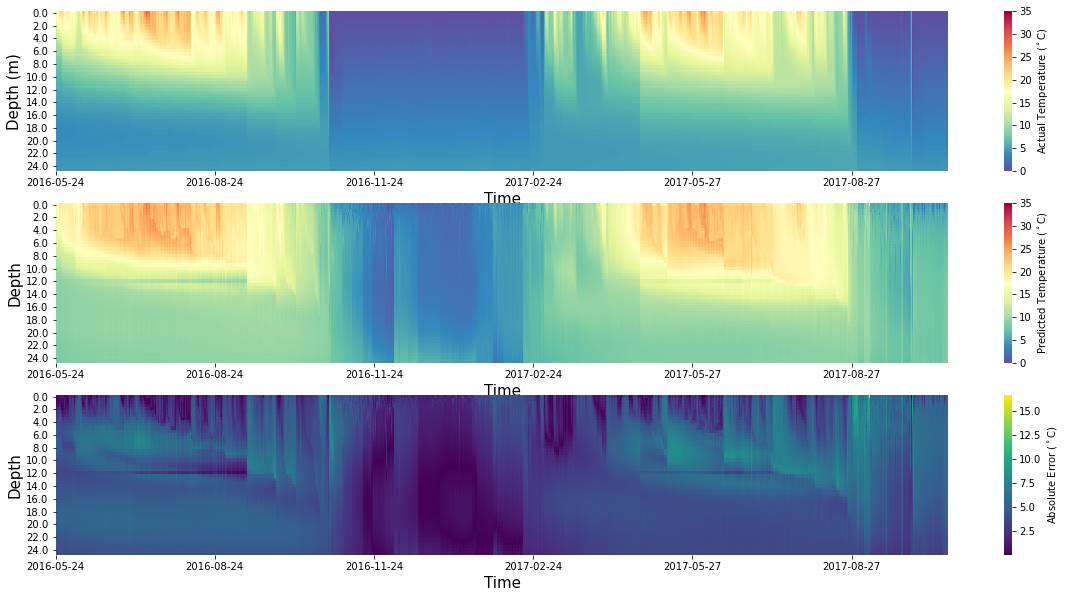

In [27]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

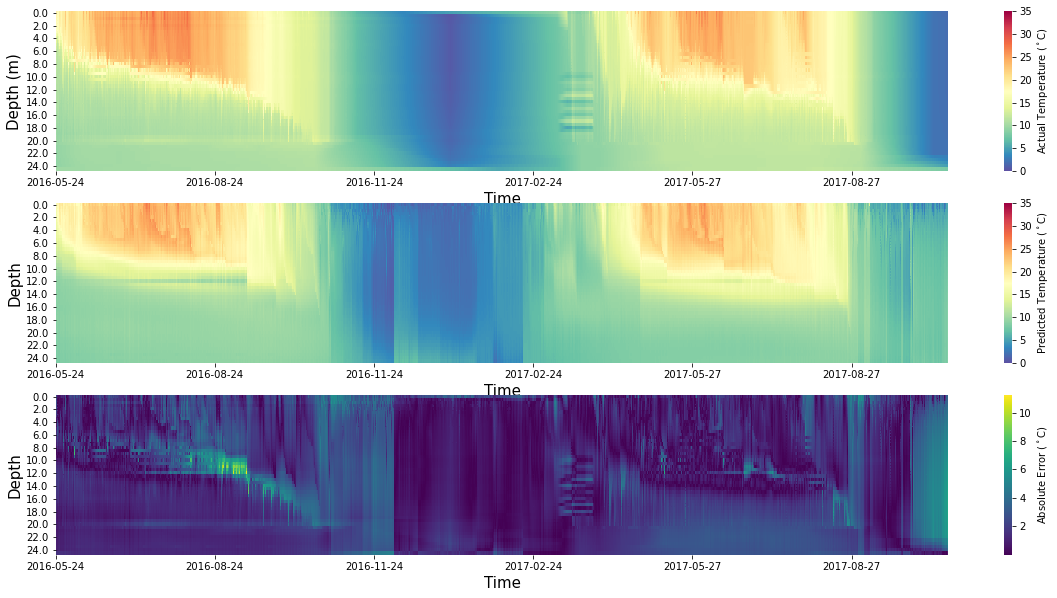

In [28]:
plot_output(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [29]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 3.834604614028479, Train L2 Error: 0.5547172250896458
Test RMSE: 4.106022987611947, Train L2 Error: 0.4746421068140304


## Mixing Model

## Convection Model

In [30]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.015163809986818539, Train L2 Error: 0.0021937284522527715
Test RMSE: 0.017966176629548223, Train L2 Error: 0.0020769408634678894


## Ice Model

In [31]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.03333344809130799, Train L2 Error: 0.004818688855386128
Test RMSE: 0.03919173269229461, Train L2 Error: 0.004527230384818891


In [118]:
def plot_output_test(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    times = time_label
    
    print(times)
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)


    sns.heatmap(y_pred.T, ax=ax, cmap='Spectral_r', vmin=0., vmax=35.)
    ax.set_ylabel("Depth (m)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    
    #  plt.legend(fontsize='x-large', title_fontsize='40')
    # ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    # ax.set_xticklabels(time_label, rotation=0)
    # new insert
    xticks_ix = np.array(ax.get_xticks()).astype(int)
    
    print(xticks_ix)
    
    time_label = times[xticks_ix]
    
    print(time_label)
    
    nelement = len(time_label)//N_pts
    
    print(nelement)
    
    time_label = time_label[::nelement]
    
    print(time_label)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax.set_xticklabels(time_label, rotation=0, fontsize = 15)
    # old code
    ax.collections[0].colorbar.set_label("Predicted Temperature ($^\circ$C)", fontsize = 15)
    yticks_ix = np.array(ax.get_yticks()).astype(int)
    
    print(yticks_ix)
    
    # depth_label = depth_steps / 25
    depth_label = yticks_ix / 2
    
    print(depth_label)
    
    nelement = len(depth_label)//5
    
    print(nelement)
    
    depth_label = depth_label[::nelement]
    
    print(depth_label)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_yticklabels(depth_label, rotation=0, fontsize = 15)

    plt.show()

['2016-05-24' '2016-05-24' '2016-05-24' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
[    0   187   374   561   748   935  1122  1309  1496  1683  1870  2057
  2244  2431  2618  2805  2992  3179  3366  3553  3740  3927  4114  4301
  4488  4675  4862  5049  5236  5423  5610  5797  5984  6171  6358  6545
  6732  6919  7106  7293  7480  7667  7854  8041  8228  8415  8602  8789
  8976  9163  9350  9537  9724  9911 10098 10285 10472 10659 10846 11033
 11220 11407 11594 11781 11968 12155 12342 12529 12716 12903 13090 13277
 13464 13651 13838]
['2016-05-24' '2016-05-31' '2016-06-08' '2016-06-16' '2016-06-24'
 '2016-07-02' '2016-07-09' '2016-07-17' '2016-07-25' '2016-08-02'
 '2016-08-10' '2016-08-17' '2016-08-25' '2016-09-02' '2016-09-10'
 '2016-09-17' '2016-09-25' '2016-10-03' '2016-10-11' '2016-10-19'
 '2016-10-26' '2016-11-03' '2016-11-11' '2016-11-19' '2016-11-26'
 '2016-12-04' '2016-12-12' '2016-12-20' '2016-12-28' '2017-01-04'
 '2017-01-12' '2017-01-20' '2017-01-28' '2017-02-05' '2017-02

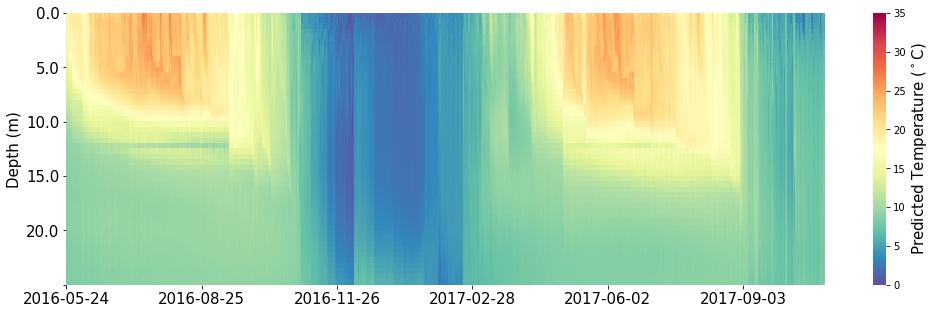

In [119]:
plot_output_test(test_y_pred, test_y_obs, depth_steps, test_time, figsize=(17,5))

In [37]:
print(test_time)
print(depth_steps)
time_label = np.array([time[:10] for time in test_time])
print(time_label)
time_label = time_label[::depth_steps]
print(time_label)

1051400    2016-05-24 02:00:00
1051401    2016-05-24 02:00:00
1051402    2016-05-24 02:00:00
1051403    2016-05-24 02:00:00
1051404    2016-05-24 02:00:00
                  ...         
1752345    2017-12-28 23:00:00
1752346    2017-12-28 23:00:00
1752347    2017-12-28 23:00:00
1752348    2017-12-28 23:00:00
1752349    2017-12-28 23:00:00
Name: time, Length: 700950, dtype: object
50
['2016-05-24' '2016-05-24' '2016-05-24' ... '2017-12-28' '2017-12-28'
 '2017-12-28']
['2016-05-24' '2016-05-24' '2016-05-24' ... '2017-12-28' '2017-12-28'
 '2017-12-28']


# Finetuning

# Freeze model weights